In [1]:
#!pip install scikit-learn --force
#!pip install catboost

In [2]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
import os
import importlib

pd.set_option('display.max.columns', 300)

from core.calculator.storage import ModelDB
from core.calculator.core import ForecastConfig
from core.calculator.core import TrainingManager
from core.calculator.core import ForecastConfig
from core.calculator.core import ForecastEngine

from core.calculator.deposits import DepositsCalculationType
from core.calculator.deposits import DepositIterativeCalculator

from core.definitions import *
from core.project_update import load_portfolio

from core.models import DepositModels
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
from core.models.utils import run_spark_session
#spark = run_spark_session('check_calc')

## Калькулятор маржи - Версия 2
### Расчет через вычисление маржи по месяцам

`agg_res` - используем как портфель  
`scenario_df` - используем для извлечения маржи  

Из всей суммы начисленных процентов выразим долю связанную с маржой и перемножим эту долю на начисленные проценты

Маржу рассчитываем из формулы по `weighted_rate`  

`VTB_weighted_rate_[segment]_[optionality]_[maturity] = VTB_ftp_rate_[maturity] - margin_[maturity] - SSV - FOR + optionality_spread + segment_spread`  

Откуда:  
`margin_[maturity] / VTB_weighted_rate_[segment]_[optionality]_[maturity] = (VTB_ftp_rate_[maturity] - SSV - FOR + optionality_spread + segment_spread) / VTB_weighted_rate_[segment]_[optionality]_[maturity] - 1`  


Умножаем interests на маржу для каждого:  
* сегмента  
* опциональности  
* срочности  

__!!!__ Подходит для flat-сценария, для боее гибкого стоит доработать исходя из перебора по

## Чтение ретро портфелей и создание выборки

In [4]:
BUCKETED_BALANCE_MAP_ = {
    1: '<100k',
    2: '100k-400k',
    3: '400k-1000k',
    4: '1000k-2000k',
    5: '>2000k'
}

In [5]:
portfolio_result_cols = [
    'report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'month_maturity','target_maturity_days', 'bucketed_balance_nm', 'bucketed_balance', 'open_month', 'close_month', 
    'weight_rate', 'balance', 'renewal_cnt', 'operations_in_month', 'early_withdrawal_in_month', 'gen_name'
    ]

In [6]:
def _add_cols_to_port(port):
    port = port.copy()
    port.loc[:, 'replenishable_flg'] = port['optional_flg'].isin([2,3]).astype(int)
    port.loc[:, 'subtraction_flg'] = port['optional_flg'].isin([1,3]).astype(int)
    port.loc[:, 'segment'] = port['is_vip_or_prv'].apply(lambda x: SEGMENT_MAP_[x])
    port.loc[:, 'month_maturity'] =  (port['bucketed_period'] - 1).astype(int)
    port.loc[:, 'target_maturity_days'] =  port.month_maturity.apply(month_to_target_maturity) 
    return port

In [7]:
def _portfolio_result(port):
    port['bucketed_balance_nm'] = port.bucketed_balance.apply(
        lambda x: BUCKETED_BALANCE_MAP_[x] if x in BUCKETED_BALANCE_MAP_ else '<100k'
    )
    port.loc[:, 'renewal_cnt'] = port.weight_renewal_cnt.round()
    port.loc[:, 'operations_in_month'] = np.where(port.optional_flg > 0, port.SER_d_cl, 0)
    port.loc[:, 'early_withdrawal_in_month'] = np.where(port.optional_flg == 0, port.SER_d_cl, 0)
    port.loc[:, 'balance'] = port.loc[:, 'total_generation']

    #port = port[port['report_dt']>self._forecast_context.portfolio_dt+MonthEnd(-1)]
    return port.sort_values(
        by = ['report_dt', 'segment', 'replenishable_flg', 'subtraction_flg', 'balance'],ascending = [True, True, True, True, False], ignore_index = True
    )

In [8]:
# читаем фактические портфели

port_res = []

for i in range(1, 8, 1):
    #print(i)
    
    port = pd.read_csv(f'/home/vtb70186744/dynbalance/data/portfolio_data/portfolio_2023-0{i}.csv', parse_dates=True)
    port['report_dt'] = pd.to_datetime(port['report_dt'])

    port_res.append(port)

In [9]:
port.sum()['total_interests'] / 10**9

156.13730427985934

In [10]:
port.head()

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic
0,2023-07,1.0,0,NaN,3.0,25.0,2006-06,2024-06,1.0,2023-07-31,50.590822,4.975650,0.01,176822.97,176822.97,1.0,1.0,18.999929,2006-06_2024-06_1.0_25.0_1.0_3_0_RUR,0.00,0.00,0.000000,0.000000,176822.97,176822.97,RUR,NaN,NaN,NaN,NaN,NaN,NaN,176805.31,14,0.948897,176822.97,0.000000
1,2023-07,4.0,0,NaN,3.0,37.0,2009-06,2024-06,1.0,2023-07-31,347.708580,34.770858,0.01,1391157.89,1391157.89,1.0,1.0,16.000000,2009-06_2024-06_4.0_37.0_1.0_3_0_RUR,0.00,0.00,0.000000,0.000000,1391157.89,1391157.89,RUR,NaN,NaN,NaN,NaN,NaN,NaN,1390879.65,26,0.938675,1391157.89,0.000000
2,2023-07,4.0,0,NaN,3.0,19.0,2009-09,2024-10,1.0,2023-07-31,426.898800,42.689880,0.01,1670907.96,1670907.96,2.0,1.0,8.000000,2009-09_2024-10_4.0_19.0_1.0_3_0_RUR,13.73,13.73,0.000008,0.000008,1670894.23,1670894.23,RUR,NaN,NaN,NaN,NaN,NaN,NaN,1670866.31,4,0.916863,1670907.96,0.000008
3,2023-07,1.0,0,NaN,3.0,14.0,2012-08,2023-11,1.0,2023-07-31,8.193900,0.819390,0.01,32783.24,32783.24,2.0,1.0,30.000000,2012-08_2023-11_1.0_14.0_1.0_3_0_RUR,0.00,0.00,0.000000,0.000000,32783.24,32783.24,RUR,NaN,NaN,NaN,NaN,NaN,NaN,32781.10,10,0.970066,32783.24,0.000000
4,2023-07,1.0,1,NaN,3.0,25.0,2014-07,2024-07,4.0,2023-07-31,2550.000000,255.000000,2.50,30781.34,30781.34,4.0,1.0,21.000000,2014-07_2024-07_1.0_25.0_4.0_3_1_RUR,0.00,0.00,0.000000,0.000000,30781.34,30781.34,RUR,NaN,NaN,NaN,NaN,NaN,NaN,30464.95,7,0.899808,30781.34,0.000000


In [11]:
port_res = pd.concat(port_res).reset_index(drop=True)

In [12]:
port_res = _add_cols_to_port(port_res)

In [13]:
port_res = _portfolio_result(port_res)

In [14]:
port_res.head(3)

,report_month,bucketed_balance,is_vip_or_prv,drop_flg,optional_flg,bucketed_period,open_month,close_month,bucketed_open_rate,report_dt,total_interests,remaining_interests,weight_rate,total_generation,total_generation_cleared,weight_renewal_cnt,weight_renewal_available_flg,weight_close_plan_day,gen_name,SER_d,SER_d_cl,SER_dinamic,SER_dinamic_cl,total_generation_lag1,total_generation_cl_lag1,CUR,report_weight_open_rate_1m,report_weight_open_rate_3m,report_weight_open_rate_6m,report_weight_open_rate_12m,report_weight_open_rate_24m,report_wo_period_weight_open_rate,init_total_generation,row_count,share_period_plan,max_total_generation,max_SER_dinamic,replenishable_flg,subtraction_flg,segment,month_maturity,target_maturity_days,bucketed_balance_nm,renewal_cnt,operations_in_month,early_withdrawal_in_month,balance
0,2023-01,4.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.080998e+09,4.309770e+08,7.014158,3.767463e+10,3.689392e+10,0.0,0.0,7.640179,2022-09_2023-03_4.0_7.0_8.0_0_0_0.0_RUR,-1.498874e+08,-3.443082e+08,-0.003963,-0.009246,3.782452e+10,3.723822e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,4.033852e+10,5,0.674033,3.767463e+10,-0.003963,0,0,mass,6,180,1000k-2000k,0.0,0.0,-3.443082e+08,3.767463e+10
1,2023-01,3.0,0,0.0,0.0,7.0,2022-09,2023-03,8.0,2023-01-31,1.039290e+09,4.140946e+08,7.014465,3.624522e+10,3.546236e+10,0.0,0.0,7.765046,2022-09_2023-03_3.0_7.0_8.0_0_0_0.0_RUR,4.100963e+07,-1.568994e+08,0.001133,-0.004405,3.620421e+10,3.561926e+10,RUR,NaN,7.0,7.490077,7.450225,NaN,7.355351,3.720755e+10,5,0.674033,3.624522e+10,0.001133,0,0,mass,6,180,400k-1000k,0.0,0.0,-1.568994e+08,3.624522e+10
2,2023-01,4.0,0,0.0,0.0,13.0,2022-09,2023-09,8.0,2023-01-31,7.430132e+08,1.515603e+09,7.000000,2.592414e+10,2.539205e+10,0.0,0.0,14.847356,2022-09_2023-09_4.0_13.0_8.0_0_0_0.0_RUR,-6.024040e+07,-1.934322e+08,-0.002318,-0.007560,2.598438e+10,2.558548e+10,RUR,NaN,7.0,7.526670,7.469240,NaN,7.404150,2.814998e+10,5,0.334247,2.592414e+10,-0.002318,0,0,mass,12,365,1000k-2000k,0.0,0.0,-1.934322e+08,2.592414e+10


In [15]:
port_res.groupby('report_dt').sum()['balance']

report_dt
2023-01-31    2.950907e+12
2023-02-28    3.000243e+12
2023-03-31    3.044367e+12
2023-04-30    3.077628e+12
2023-05-31    3.131640e+12
2023-06-30    3.148000e+12
2023-07-31    2.990741e+12
Name: balance, dtype: float64

In [16]:
port_res['interests'] = port_res['total_generation'] - port_res['total_generation_lag1'].astype(float) - port_res['SER_d_cl']

In [17]:
from pandas.tseries.offsets import MonthEnd

In [18]:
portfolio_res = port_res.copy()

In [19]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month'], format='%Y-%m')

##### 

In [20]:
portfolio_res['target_maturity_days'].unique()

array([ 180,  365,   90, 1095,  548,  730])

In [21]:
maturity_dict = {90: 3,
                180: 6,
                365: 12,
                548: 18,
                730: 24,
                1095: 36}

In [22]:
# корректируем месяца
portfolio_res['target_maturity_months'] = portfolio_res['target_maturity_days'].replace(maturity_dict)

Сделаем поле open_month_correct и нормальную дату открытия для каждого депозита

In [23]:
portfolio_res.renewal_cnt.unique()

array([ 0.,  1.,  4.,  2.,  8.,  9.,  7.,  5.,  6.,  3., 10., 11.])

<AxesSubplot:>

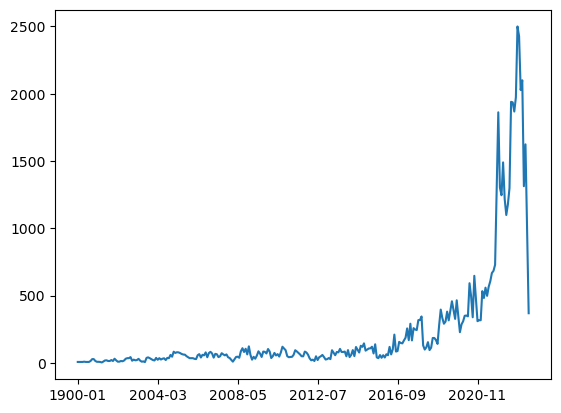

In [24]:
portfolio_res['open_month'].value_counts().sort_index().plot()

In [25]:
# 99 процентов занимают депозиты открытые позже 2017

portfolio_res[portfolio_res['open_month']>='2017-01']['balance'].sum() / portfolio_res['balance'].sum()

0.9998023064063406

## Корректируем дату открытия относительно даты закрытия для депозитов с пролонгацией

In [26]:
from pandas.tseries.offsets import MonthEnd

In [27]:
portfolio_res[portfolio_res['renewal_cnt']>0][['open_month', 'close_month', 'month_maturity', 'renewal_cnt']]

,open_month,close_month,month_maturity,renewal_cnt
29,2022-10,2023-04,3,1.0
36,2022-10,2023-04,3,1.0
76,2022-10,2023-04,3,1.0
88,2022-09,2023-03,3,1.0
94,2022-09,2023-03,3,1.0
...,...,...,...,...
63789,2014-12,2023-12,12,2.0
63790,2015-02,2024-02,12,2.0
63791,2009-11,2023-12,12,2.0
63792,2019-05,2025-06,36,1.0


 Формула расчета даты открытия к которой будет происходить джойн для депозитов где renewal_cnt>0: `дата закрытия` - `month_maturity`

In [28]:
portfolio_res['close_month_dt'] = pd.to_datetime(portfolio_res['close_month']) 

In [29]:
portfolio_res['open_month_correct'] = pd.to_datetime(portfolio_res['open_month']) 

In [30]:
portfolio_res['target_maturity_months'].unique()

array([ 6, 12,  3, 36, 18, 24])

In [31]:
for mat in portfolio_res['target_maturity_months'].unique():
    
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['close_month_dt'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] +  MonthEnd(-mat)
    
    
    portfolio_res['open_month'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)] = \
    portfolio_res['open_month_correct'][(portfolio_res['renewal_cnt']>0)&(portfolio_res['target_maturity_months']==mat)].apply(lambda x: str(x)[:7])

<AxesSubplot:>

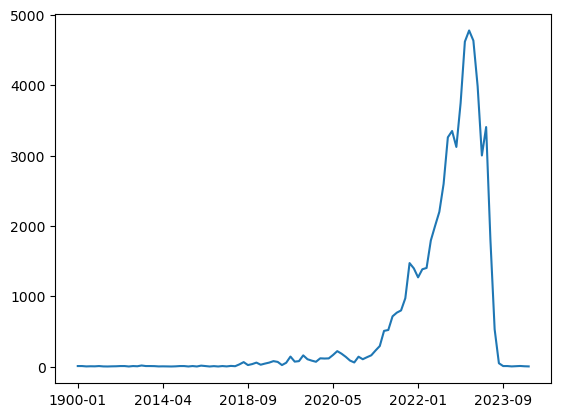

In [32]:
portfolio_res['open_month'].value_counts().sort_index().plot()

## Джойн FTP ставок

In [33]:
# Код выгрузки

query = """
SELECT 
year(report_date) as report_year, 
month(report_date) as report_month, 
AVG(`vtb_[1095d]_ftp_rate`) as `VTB_[1095d]_ftp_rate`, 
AVG(`vtb_[180d]_ftp_rate`) as `VTB_[180d]_ftp_rate`,
AVG(`vtb_[365d]_ftp_rate`) as `VTB_[365d]_ftp_rate`,
AVG(`vtb_[548d]_ftp_rate`) as `VTB_[548d]_ftp_rate`,
AVG(`vtb_[730d]_ftp_rate`) as `VTB_[730d]_ftp_rate`,
AVG(`vtb_[90d]_ftp_rate`) as `VTB_[90d]_ftp_rate`

FROM dadm_alm_sbx.vtb_ftp_rates 

GROUP BY year(report_date), month(report_date)
ORDER BY year(report_date) desc, month(report_date) desc;
"""

In [34]:
ftp_table = pd.read_csv('ftp.csv')

In [35]:
ftp_table['report_month'][ftp_table['report_month']<=9] = ftp_table['report_month'][ftp_table['report_month']<=9].apply(lambda x: '0'+str(x))

In [36]:
ftp_table['report_month'] = ftp_table['report_month'].astype(str)

In [37]:
ftp_table['report_year'] = ftp_table['report_year'].astype(str)

In [38]:
ftp_table['open_month'] = ftp_table['report_year'] + '-' + ftp_table['report_month']

In [39]:
del ftp_table['report_month']
del ftp_table['report_year']

In [40]:
# дополнить этот момент
# для новых вкладов лучше брать новые ставки

portfolio_res['open_month'][portfolio_res['open_month']>'2023-09'] = '2023-09'

portfolio_res = portfolio_res.merge(ftp_table, on='open_month', how='left')

In [41]:
portfolio_res['ftp'] = np.nan



for day in portfolio_res['target_maturity_days'].unique():
    
    # выбираем колонку
    col = f'vtb_[{day}d]_ftp_rate'
    
    portfolio_res['ftp'][portfolio_res['target_maturity_days']==day] = portfolio_res[col][portfolio_res['target_maturity_days']==day]

In [42]:
portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum()

8035796.890000001

In [43]:
# доля пропусков

portfolio_res[portfolio_res['ftp'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

3.7649811342871016e-07

In [44]:
portfolio_res[portfolio_res['ftp'].isnull()]['open_month'].value_counts().sort_index()

1900-01    7
1994-01    7
2005-02    2
2005-03    4
2005-04    3
2005-09    7
2007-01    2
2007-02    1
2009-02    1
2010-11    7
2011-05    4
2014-07    1
2017-03    2
Name: open_month, dtype: int64

формула для пролонгаций = дата открытия + срочность * число пролонгаций - это фактическая open_dt   

Можно подойти через плановая дата закрытия - срочность  

In [45]:
d = {'2023-01': [3], 
     '2023-02': [3], 
     '2023-03': [4], 
     '2023-04': [4], 
     '2023-05': [4], 
     '2023-06': [4.5],
     '2023-07': [4.5]}

In [46]:
FOR = pd.DataFrame(data=d, index=None).T

In [47]:
FOR = FOR.reset_index().rename(columns={'index': 'report_month', 0: 'FOR'})

In [48]:
portfolio_res = portfolio_res.merge(FOR, on='report_month', how='left')

In [49]:
portfolio_res['SSV'] = 0.48

### Найдем взвешанные FTP ставки 

In [50]:
portfolio_res['balance_x_ftp'] = portfolio_res['balance'] * portfolio_res['ftp']

In [51]:
(portfolio_res.groupby('report_month').sum()['balance_x_ftp'] / portfolio_res.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,9.06779,8.952411,8.961927,8.704633,8.5601,8.576667,8.579139


In [52]:
portfolio_res.groupby('report_month').sum()['balance']

report_month
2023-01    2.950907e+12
2023-02    3.000243e+12
2023-03    3.044367e+12
2023-04    3.077628e+12
2023-05    3.131640e+12
2023-06    3.148000e+12
2023-07    2.990741e+12
Name: balance, dtype: float64

## Сравним FTP для оттоков 

In [53]:
portfolo_res3 = portfolio_res.copy()

In [54]:
portfolo_res3['balance'] = portfolo_res3['balance'] - port_res['SER_d_cl']

In [55]:
portfolo_res3['balance_x_ftp'] = portfolo_res3['balance'] * portfolo_res3['ftp']

In [56]:
(portfolo_res3.groupby('report_month').sum()['balance_x_ftp'] / portfolo_res3.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,9.11807,8.943081,9.0974,8.716419,8.570128,8.589512,8.574114


### Найдем взвешанные ставки по депозитам

In [57]:
portfolio_res['balance_x_weight_rate'] = portfolio_res['balance'] * portfolio_res['weight_rate']

In [58]:
(portfolio_res.groupby('report_month').sum()['balance_x_weight_rate'] / portfolio_res.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,7.459766,7.285003,7.340237,7.279567,7.231137,7.235336,7.210445


## Взвешанные ставки с учетом оттоков

In [59]:
portfolo_res3['balance_x_weight_rate'] = portfolo_res3['balance'] * portfolo_res3['weight_rate']

In [60]:
(portfolo_res3.groupby('report_month').sum()['balance_x_weight_rate'] / portfolo_res3.groupby('report_month').sum()['balance']).reset_index().T

,0,1,2,3,4,5,6
report_month,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07
0,7.488949,7.302237,7.393401,7.295637,7.259178,7.254725,7.211382


### Вычтем FOR и SSV и перейдем к расчетам

In [61]:
portfolio_res['ftp'] = portfolio_res['ftp'] * (1 - portfolio_res['FOR']/100) - portfolio_res['SSV']

### Расчет ЧПД

In [62]:
portfolio_res['margin_year'] = portfolio_res['ftp'] - portfolio_res['weight_rate']

In [63]:
portfolio_res[portfolio_res['margin_year'].isnull()]['balance'].sum() / portfolio_res['balance'].sum()

3.7649811342871016e-07

In [64]:
portfolio_res.groupby('report_month').mean()['margin_year']

report_month
2023-01    4.322952
2023-02    4.275824
2023-03    3.924336
2023-04    3.695995
2023-05    3.592223
2023-06    3.686777
2023-07    3.743985
Name: margin_year, dtype: float64

In [65]:
portfolio_res['margin_year']

0        0.160407
1        0.160100
2        0.280000
3        0.280000
4        0.840485
           ...   
63789    7.675250
63790    7.675250
63791    7.675250
63792    8.559762
63793    7.150000
Name: margin_year, Length: 63794, dtype: float64

In [66]:
portfolio_res['margin_month'] = (1+(portfolio_res['margin_year']/100))**(1/12) - 1

In [67]:
portfolio_res['margin_month']

0        0.000134
1        0.000133
2        0.000233
3        0.000233
4        0.000698
           ...   
63789    0.006181
63790    0.006181
63791    0.006181
63792    0.006868
63793    0.005772
Name: margin_month, Length: 63794, dtype: float64

In [68]:
portfolio_res['margin_year']

0        0.160407
1        0.160100
2        0.280000
3        0.280000
4        0.840485
           ...   
63789    7.675250
63790    7.675250
63791    7.675250
63792    8.559762
63793    7.150000
Name: margin_year, Length: 63794, dtype: float64

In [69]:
portfolio_res['margin_day'] = (portfolio_res['margin_year']/100)*(1/365)

In [70]:
int(portfolio_res['report_dt'].astype(str).iloc[1][-2:])

31

In [71]:
portfolio_res['report_dt_days'] = portfolio_res['report_dt'].apply(lambda x: (x.day))

In [72]:
portfolio_res['margin_value'] = portfolio_res['balance'] * portfolio_res['margin_day'] * portfolio_res['report_dt_days']

In [73]:
portfolio_res['margin_value'] = portfolio_res['balance'] * portfolio_res['margin_month'] #* portfolio_res['report_dt_days']

In [74]:
#portfolio_res['margin_value'] = (portfolio_res['balance'] - portfolio_res['SER_d_cl']) * portfolio_res['margin_month']

## Идея - при досрочном отзыве не откатываются проценты по депозитам части клиентов

In [75]:
portfolio_res.groupby('report_dt').sum()['margin_value'].reset_index().T

,0,1,2,3,4,5,6
report_dt,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00
margin_value,2067905840.138926,2255681059.577069,1951548682.826265,1514047837.936218,1310268092.394586,1234291028.186403,1239651289.083116


In [76]:
(portfolio_res.groupby('report_dt').sum()['margin_value'] / portfolio_res.groupby('report_dt').sum()['balance'])*100*10

report_dt
2023-01-31    0.700770
2023-02-28    0.751833
2023-03-31    0.641036
2023-04-30    0.491953
2023-05-31    0.418397
2023-06-30    0.392087
2023-07-31    0.414496
dtype: float64

In [77]:
import seaborn as sns

<AxesSubplot:xlabel='margin_month', ylabel='Density'>

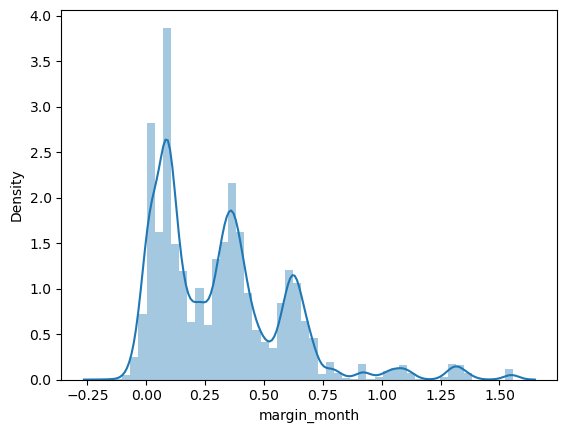

In [78]:
sns.distplot(portfolio_res['margin_month']*100)

<AxesSubplot:xlabel='margin_month', ylabel='Density'>

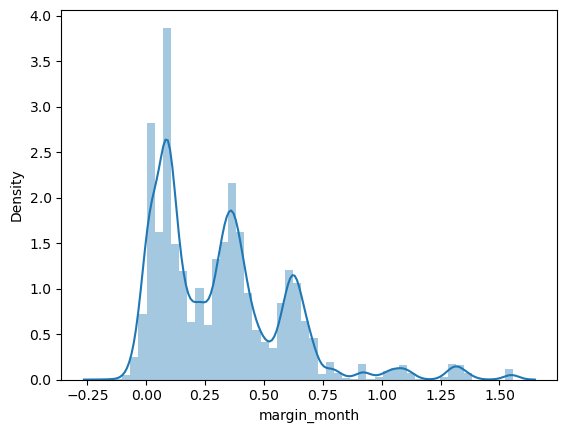

In [79]:
sns.distplot(portfolio_res['margin_month']*100)